In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

import networkx as nx

from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.simulate import simulate_networks
from inv_vae.utils.helpers import Namespace, reset_weights
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

simulate data

In [407]:
n_nodes = 68
p_in = .25
p_out = .01
n_noisy_nets = 200
# noise_levels = np.array([0.9, 0.5, 0.1, 0.01, 0.001])
noise_levels = np.array([0.1, 1e-2, 1e-3, 1e-4, 1e-5])
noise_sds = noise_levels.copy()

In [408]:
np.random.seed(seed)
# simulate noises
noises = np.zeros(n_noisy_nets * len(noise_levels))
noise_ids = np.zeros_like(noises)
for i in range(len(noise_levels)):
    noises[i*n_noisy_nets:(i+1)*n_noisy_nets] = np.random.normal(noise_levels[i], noise_sds[i], n_noisy_nets)
    noise_ids[i*n_noisy_nets:(i+1)*n_noisy_nets] = i

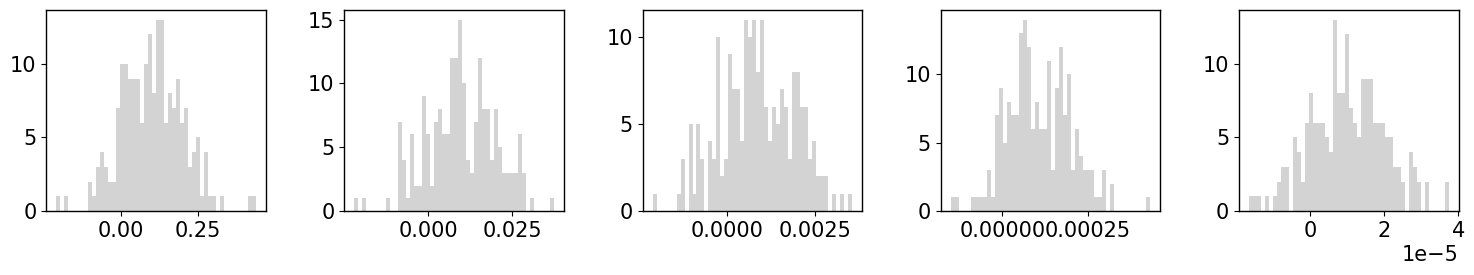

In [409]:
fig, axes = plt.subplots(1, 5, figsize=(15,3))
for i in range(len(noise_levels)):
    axes[i].hist(noises[i*n_noisy_nets:(i+1)*n_noisy_nets], 50, color="lightgray");
plt.tight_layout()

In [410]:
noises = np.hstack([np.ones(n_noisy_nets), noises])

In [411]:
all_nets = []
for i in range(len(noises)):
    G = nx.random_partition_graph([n_nodes//2, n_nodes//2], p_in, p_out)
    A = nx.to_scipy_sparse_array(G).todense().reshape(n_nodes, n_nodes)    
    start_idx = i*n_noisy_nets
    end_idx = (i+1)*n_noisy_nets
    noisy_A = np.matmul(noises[i]*A, noises[i]*A)
    noisy_A[range(n_nodes), range(n_nodes)] = 0
    all_nets.append(noisy_A)
all_nets = np.array(all_nets)

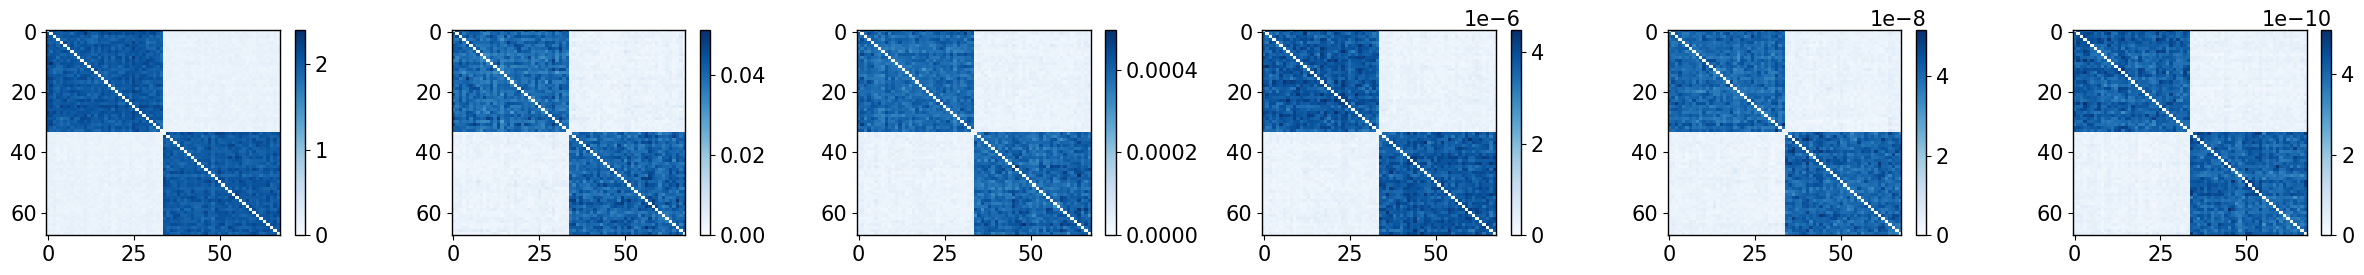

In [412]:
fig, axes = plt.subplots(1, 6, figsize=(24,3))
for i in range(len(noise_levels)+1):
    im = axes[i].imshow(all_nets[i*n_noisy_nets:(i+1)*n_noisy_nets].mean(0),
                        aspect="auto", cmap="Blues");
    plt.colorbar(im, ax=axes[i])
plt.tight_layout()

In [413]:
# np.save("../saved_res/all_nets.npy", all_nets)

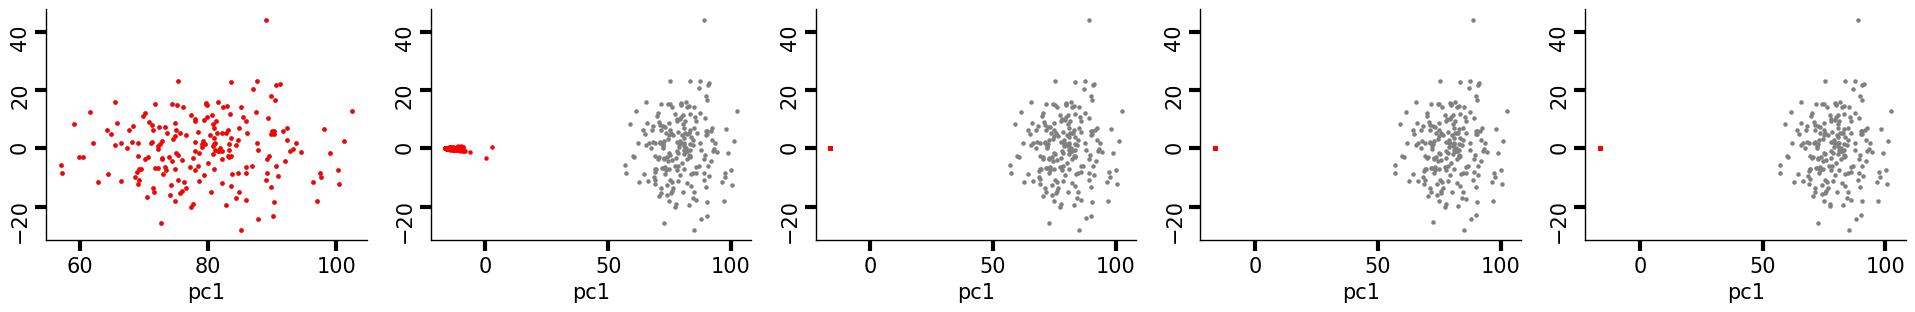

In [414]:
fig, axes = plt.subplots(1, 5, figsize=(24,3))
for i in range(len(noise_levels)):
    start_idx = i*n_noisy_nets
    end_idx = (i+1)*n_noisy_nets
    
    pca = PCA(2)
    all_Xt = pca.fit_transform(all_nets.reshape(-1, n_nodes*n_nodes))
    all_df = pd.DataFrame({"pc1": all_Xt[:,0], "pc2": all_Xt[:,1], "noise": noises})
    
    im = axes[i].scatter(x="pc1", y="pc2", color="gray", data=all_df.iloc[:n_noisy_nets], s=5, alpha=1.)
    im = axes[i].scatter(x="pc1", y="pc2", color="red", data=all_df.iloc[start_idx:end_idx], s=5, alpha=1.)
    axes[i].set_xlabel('pc1')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].tick_params(axis='y', labelrotation=90, length=8, width=3)
    axes[i].tick_params(axis='x', length=8, width=3)

prepare datasets for training

In [415]:
config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=1,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = 100., gamma = .1, add_reg = False, y_dim = 0,               
    batch_size=32, n_epochs=200, lr=5e-4, device=DEVICE)

In [416]:
A_mat = np.mean(all_nets, axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i).float().to(config.device) for i in range(config.n_dec_layers)]

In [417]:
n_nets = len(all_nets)
ids = list(range(n_nets))
random.shuffle(ids)
train_ids = ids[:int(.9*n_nets)]
val_ids = ids[int(.9*n_nets):]
print(len(train_ids), len(val_ids))
tensor_nets = torch.stack([torch.Tensor(i) for i in list(all_nets)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_noises = torch.from_numpy(noises).to(torch.float32).view(-1, 1)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_noises[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_noises[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

1080 120


inv-vae

In [418]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [ ]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.custom_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.custom_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

epoch: 0 train loss: 1436.170 nll: 2379.390 kl: 1.275 inv_loss: 0.133
epoch: 0 test loss 1231.275 nll: 2237.017 kl: 0.009 inv_loss: 0.000
epoch: 5 train loss: 1084.983 nll: 1970.840 kl: 0.010 inv_loss: 0.000
epoch: 5 test loss 1107.386 nll: 2010.701 kl: 0.015 inv_loss: 0.001


In [ ]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [398]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()
x_recon = inv_model.decode(
                z_sample, tensor_noises.to(config.device)
          ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)
x_denoised = inv_model.decode(
                z_sample, torch.ones_like(tensor_noises).to(config.device)
          ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

In [399]:
pca = PCA(2)
inv_vae_Xt = pca.fit_transform(inv_latents)
inv_vae_df = pd.DataFrame({"pc1": inv_vae_Xt[:,0], "pc2": inv_vae_Xt[:,1], "noise": noises})

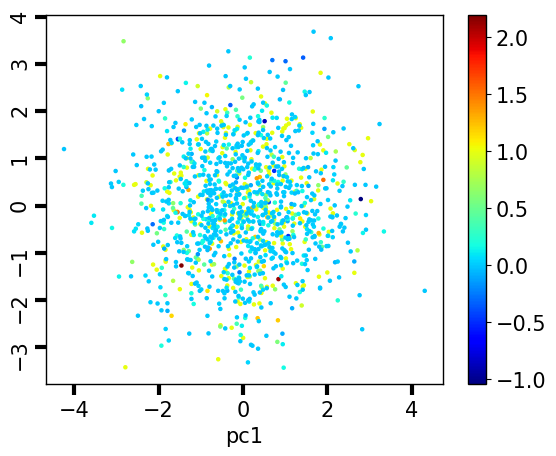

In [400]:
plt.scatter(x="pc1", y="pc2", c=noises, cmap="jet", data=inv_vae_df, s=5, alpha=1.)
plt.xlabel('pc1')
plt.tick_params(axis='y', labelrotation=90, length=8, width=3)
plt.tick_params(axis='x', length=8, width=3)
plt.colorbar();

single-subject analysis

In [401]:
n=39
x = 0.32 
cmap = plt.cm.jet
lower = cmap(np.linspace(0, x, n))
white = np.ones((80-2*n,4))
upper = cmap(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
div_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('div_cmap', colors)

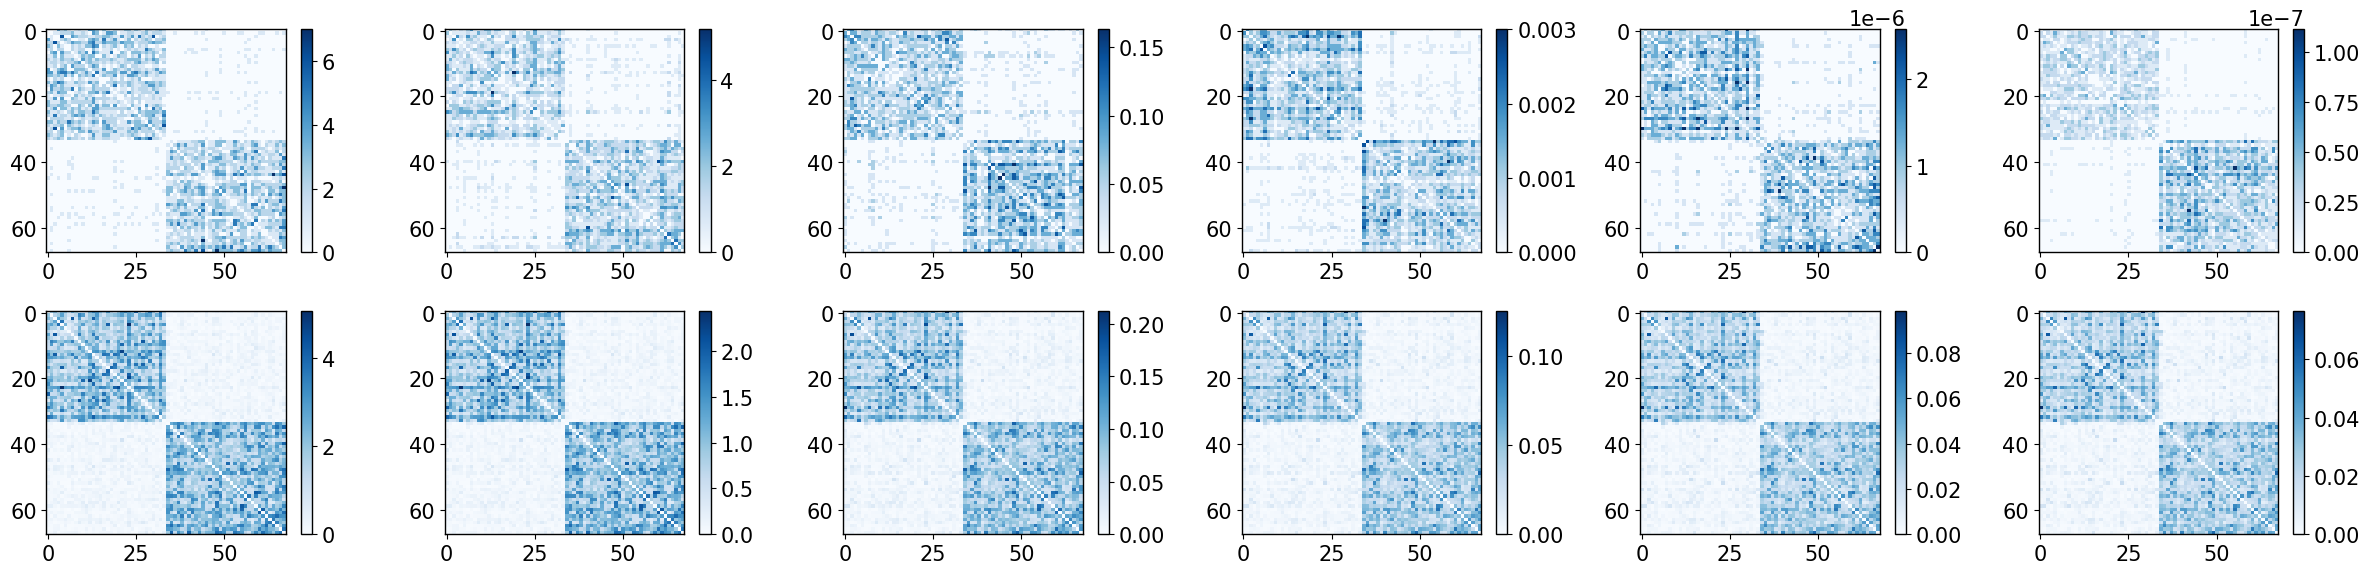

In [402]:
sub_idx = 100

fig, axes = plt.subplots(2, 6, figsize=(24,6))
for i in range(len(noise_levels)+1):
    im = axes[0,i].imshow(all_nets[i*n_noisy_nets:(i+1)*n_noisy_nets][sub_idx],
                        aspect="auto", cmap="Blues", vmin=0);
    plt.colorbar(im, ax=axes[0,i])
    
im = axes[1,0].imshow(x_recon[sub_idx], aspect="auto", cmap="Blues");
for i in range(len(noise_levels)+1):
    im = axes[1,i].imshow(x_recon[i*n_noisy_nets:(i+1)*n_noisy_nets][sub_idx],
                        aspect="auto", cmap="Blues", vmin=0);
    plt.colorbar(im, ax=axes[1,i])
plt.tight_layout()

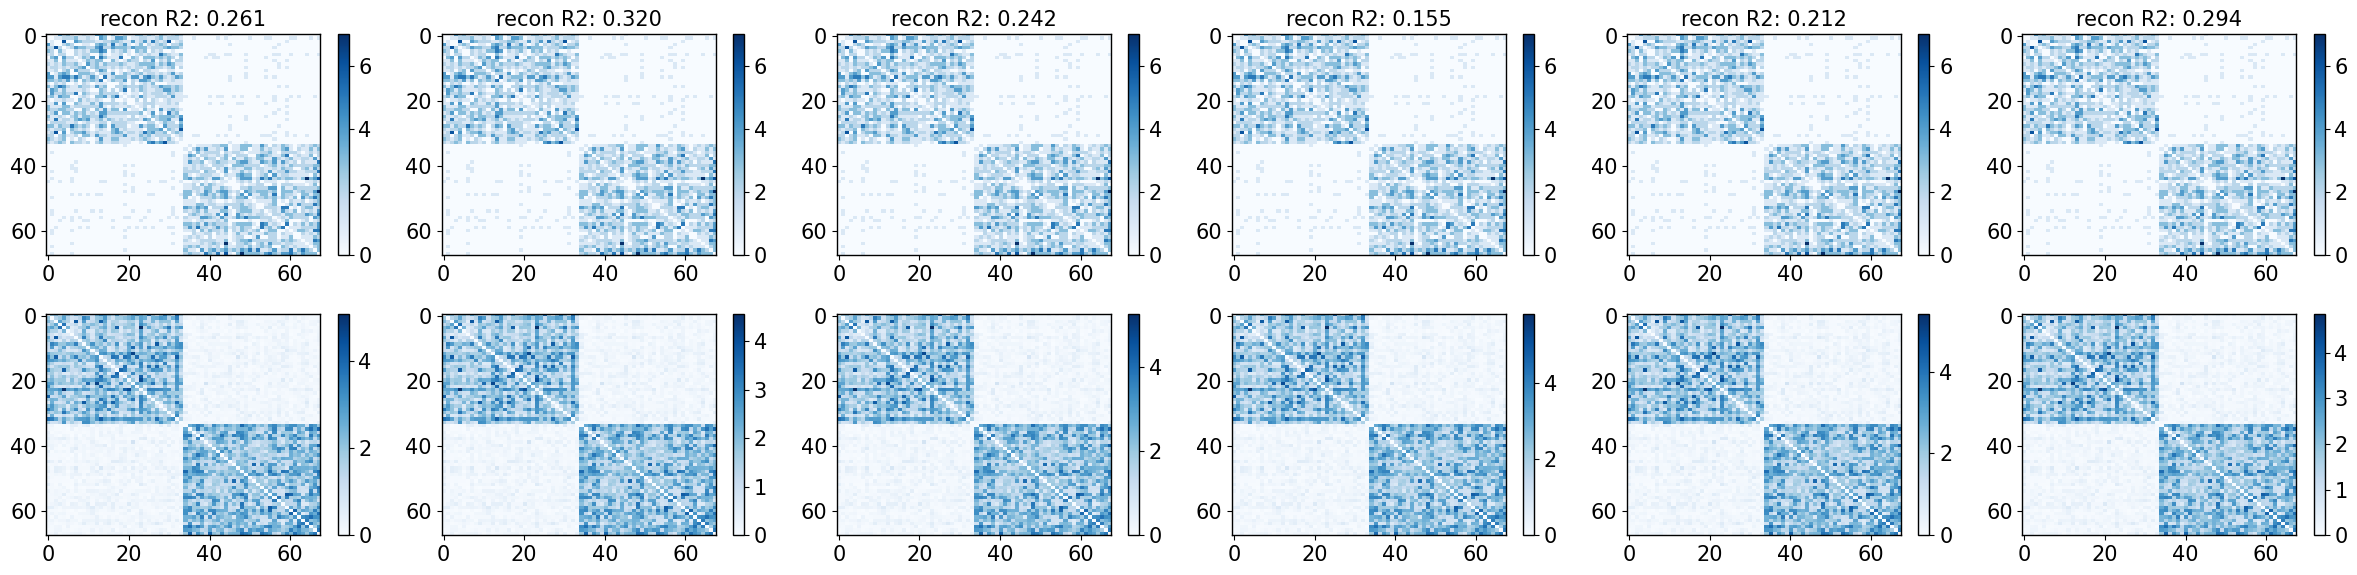

In [403]:
sub_idx = 100

fig, axes = plt.subplots(2, 6, figsize=(24,6))
im = axes[1,0].imshow(x_recon[sub_idx], aspect="auto", cmap="Blues");
for i in range(len(noise_levels)+1):
    im = axes[0,i].imshow(all_nets[sub_idx],
                        aspect="auto", cmap="Blues", vmin=0);
    plt.colorbar(im, ax=axes[0,i])
    
    offset = 1.
    r2 = explained_variance_score(all_nets[sub_idx], x_denoised[i*n_noisy_nets:(i+1)*n_noisy_nets][sub_idx]*offset)
    im = axes[1,i].imshow(x_denoised[i*n_noisy_nets:(i+1)*n_noisy_nets][sub_idx]*offset,
                        aspect="auto", cmap="Blues", vmin=0)
    axes[0,i].set_title(f"recon R2: {r2:.3f}")
    plt.colorbar(im, ax=axes[1,i])
plt.tight_layout()

In [404]:
def kl_mvn(m0, S0, m1, S1):
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    return .5 * (tr_term + det_term + quad_term - N) 

In [405]:
pca = PCA(2)
z_mean_low_dim = pca.fit_transform(z_mean.detach().cpu().numpy())
z_var_low_dim = pca.fit_transform(z_logvar.detach().cpu().numpy())

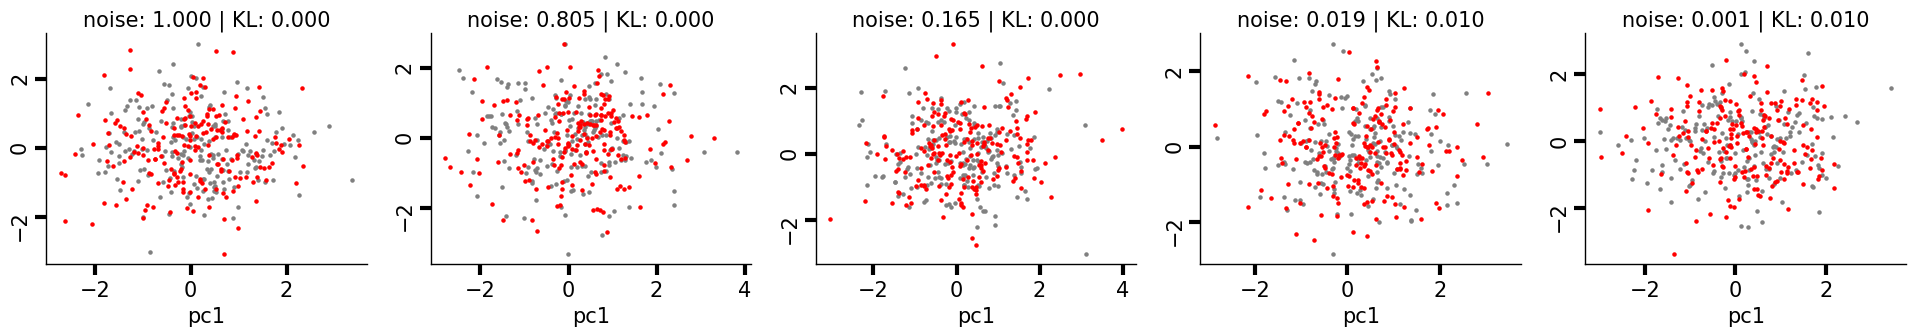

In [406]:
fig, axes = plt.subplots(1, 5, figsize=(24,3))
for i in range(len(noise_levels)):
    start_idx = i*n_noisy_nets
    end_idx = (i+1)*n_noisy_nets
    
    sim_z0 = np.random.normal(z_mean_low_dim[sub_idx][0], np.exp(z_mean_low_dim)[sub_idx][0], 200)
    sim_z1 = np.random.normal(z_mean_low_dim[sub_idx][1], np.exp(z_mean_low_dim)[sub_idx][1], 200)
    noisy_z0 = np.random.normal(z_mean_low_dim[start_idx:end_idx][sub_idx][0], np.exp(z_mean_low_dim)[sub_idx][0], 200)
    noisy_z1 = np.random.normal(z_mean_low_dim[start_idx:end_idx][sub_idx][1], np.exp(z_mean_low_dim)[sub_idx][1], 200)
    
    m0 = np.c_[z_mean_low_dim[sub_idx][0], z_mean_low_dim[sub_idx][1]].squeeze()
    m1 = np.c_[z_mean_low_dim[start_idx:end_idx][sub_idx][0], z_mean_low_dim[start_idx:end_idx][sub_idx][1]].squeeze()
    S0 = np.eye(2)
    np.fill_diagonal(S0, [np.exp(z_mean_low_dim)[sub_idx][0], np.exp(z_mean_low_dim)[sub_idx][1]])
    S1 = np.eye(2)
    np.fill_diagonal(S1, [np.exp(z_mean_low_dim)[start_idx:end_idx][sub_idx][0], np.exp(z_mean_low_dim)[start_idx:end_idx][sub_idx][1]])
    kl = (kl_mvn(m0, S0, m1, S1) + kl_mvn(m1, S1, m0, S0)) / 2
    
    im = axes[i].scatter(x=sim_z0, y=sim_z1, color="gray", s=5, alpha=1.)
    im = axes[i].scatter(x=noisy_z0, y=noisy_z1, color="red", s=5, alpha=1.)
    axes[i].set_title(
        f"noise: {noises[start_idx:end_idx][sub_idx]:.3f} | KL: {kl:.3f}"
    )
    axes[i].set_xlabel('pc1')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].tick_params(axis='y', labelrotation=90, length=8, width=3)
    axes[i].tick_params(axis='x', length=8, width=3)

population-level analysis